In [1]:
from webscrape import get_all_stats, get_clubs_stats # Funções criadas para facilitar a extração de dados.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import norm

from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import r2_score

# Pergunta 2: Há alguma relação entre goleiros com mais cleansheets (partidas sem sofrer gols) e times com mais pontos?

## Análise exploratória

Para responder a pergunta 2, serão utilizadas apenas as tabelas serie_A_overall e squad_goalkeeping, com dados de 2014 à 2024. Com ela saberemos estatísticas relevantes como pontos dos times, clean sheets, gols e demais informações.

In [2]:
stats = get_all_stats(['serie_A_overall', 'squad_goalkeeping'])

In [3]:
# Colunas a serem utilizadas na análise
colunas_goalkeeping = ['Squad', 'CS', 'GA', 'SoTA', 'Saves', 'CS%', 'PKatt', 'PKsv', 'Save%', 'Ano']
colunas_overall = ['Squad', 'MP', 'W', 'D', 'L', 'GF', 'GA', 'Pts', 'Poss', 'Ano']

goalkeeping_list = []
overall_list = []

for key, df in stats.items():
    df = df.copy()
    ano = int(key.split('_')[-1])

    if "goalkeeping" in key:
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(1)
        df["Ano"] = ano
        df = df[[col for col in colunas_goalkeeping if col in df.columns]]  # só mantém colunas desejadas
        goalkeeping_list.append(df)

    elif "overall" in key:
        df["Ano"] = ano
        df = df[[col for col in colunas_overall if col in df.columns]]
        overall_list.append(df)

A tabela resultante terá apenas os dados importantes para a nossa análise. Ainda será acrescentada o ano de cada tupla de informações para análises sazonais futuramente.

In [4]:
df_goalkeeping = pd.concat(goalkeeping_list, ignore_index=True)
df_overall = pd.concat(overall_list, ignore_index=True)

df_question2 = pd.merge(df_goalkeeping, df_overall, on=["Squad", "Ano"], suffixes=('_gk', '_ov'))
df_question2.shape

(220, 18)

In [5]:
sns.set(style="whitegrid")

# Garante que as colunas estão com tipos corretos
df_question2['CS'] = pd.to_numeric(df_question2['CS'], errors='coerce')
df_question2['Pts'] = pd.to_numeric(df_question2['Pts'], errors='coerce')

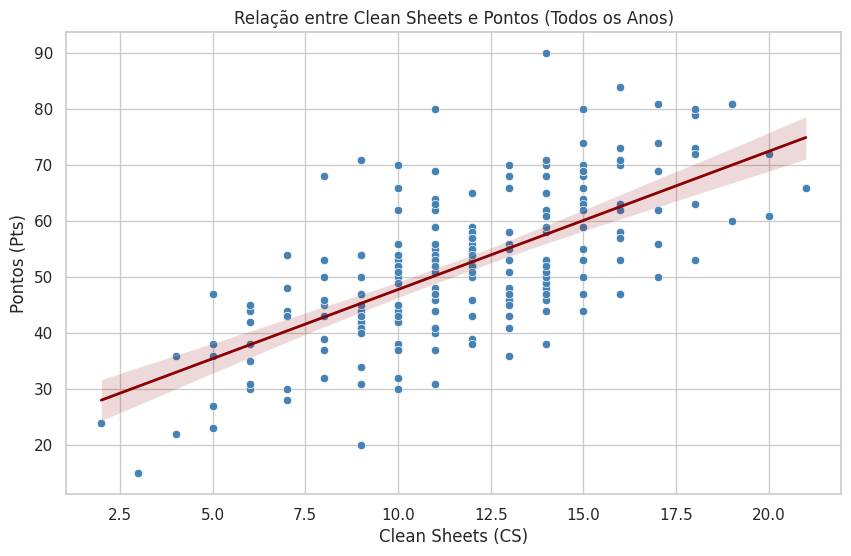

In [6]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_question2, x="CS", y="Pts", color='steelblue')
sns.regplot(data=df_question2, x="CS", y="Pts", scatter=False, color='darkred', line_kws={'linewidth':2})
plt.title("Relação entre Clean Sheets e Pontos (Todos os Anos)")
plt.xlabel("Clean Sheets (CS)")
plt.ylabel("Pontos (Pts)")
plt.show()

                            OLS Regression Results                            
Dep. Variable:                    Pts   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     131.0
Date:                Sun, 22 Jun 2025   Prob (F-statistic):           5.66e-23
Time:                        13:00:36   Log-Likelihood:                -649.64
No. Observations:                 176   AIC:                             1303.
Df Residuals:                     174   BIC:                             1310.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.9940      2.592      9.257      0.0

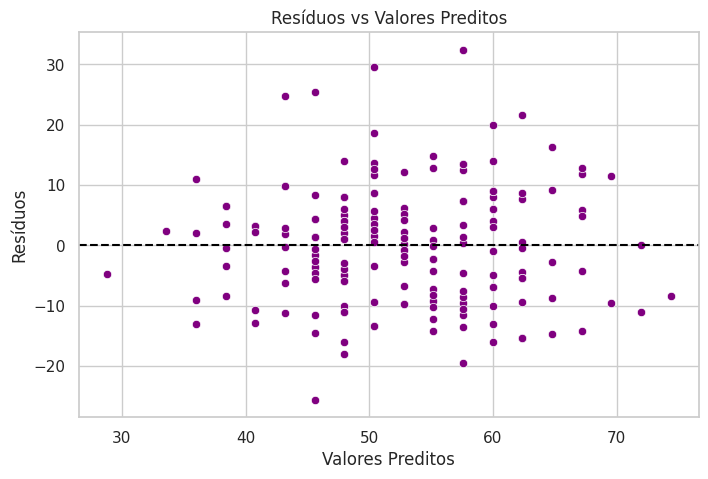

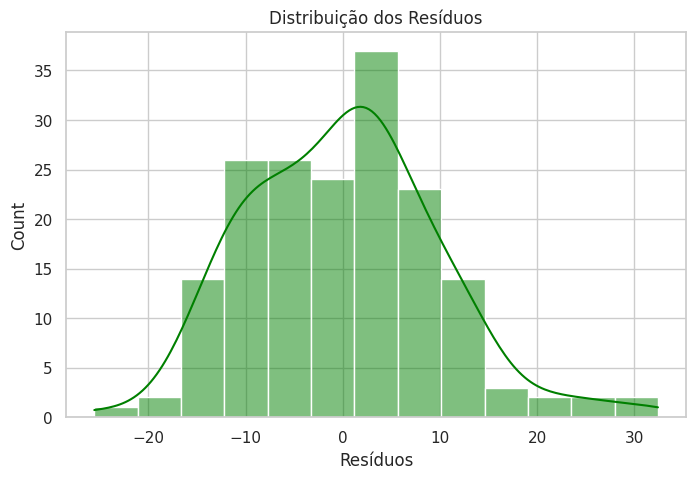

ValueError: The data contains non-finite values.

In [8]:
# Remove linhas com valores nulos em CS ou Pts
df_valid = df_question2.dropna(subset=['CS', 'Pts'])

# Variáveis
X = df_valid[['CS']]
y = df_valid['Pts']

# Adiciona constante para o intercepto
#X_with_const = sm.add_constant(X)

# Ajusta o modelo de regressão linear
#model = sm.OLS(y, X_with_const).fit()



# Divide em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Adiciona constante (intercepto) ao treino
X_train_const = sm.add_constant(X_train)

# Ajusta o modelo nos dados de treino
model = sm.OLS(y_train, X_train_const).fit()

# Avalia o modelo nos dados de teste
X_test_const = sm.add_constant(X_test)
y_pred = model.predict(X_test_const)


# Printa o resumo estatístico completo
print(model.summary())

# -------------------------------
# Diagnóstico gráfico
# -------------------------------

# Predições
y_pred = model.predict(X_train_const)
residuos = y - y_pred

# 1. Resíduos vs Preditos
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred, y=residuos, color='purple')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')
plt.title('Resíduos vs Valores Preditos')
plt.show()

# 2. Histograma dos resíduos (para verificar distribuição normal)
plt.figure(figsize=(8,5))
sns.histplot(residuos, kde=True, color='green')
plt.title('Distribuição dos Resíduos')
plt.xlabel('Resíduos')
plt.show()

# 3. QQ-Plot dos resíduos (verificar normalidade)
sm.qqplot(residuos, line='45', fit=True)
plt.title('QQ Plot dos Resíduos')
plt.show()

# 4. Teste de Shapiro-Wilk para normalidade dos resíduos
#shapiro_test = stats.shapiro(residuos)
#print(f"Shapiro-Wilk Teste: Estatística={shapiro_test.statistic:.4f}, p-valor={shapiro_test.pvalue:.4f}")

# 5. R² manual (comparando com o que o statsmodels calculou)
r2_manual = r2_score(y, y_pred)
print(f'R² manual: {r2_manual:.4f}')

O gráfico de dispersão entre clean sheets e pontos evidencia uma relação positiva (quanto maior o número de partidas sem sofrer gols, maior a pontuação do time). A linha de regressão e a faixa de confiança indicam uma tendência consistente, ainda que haja variações entre os times.

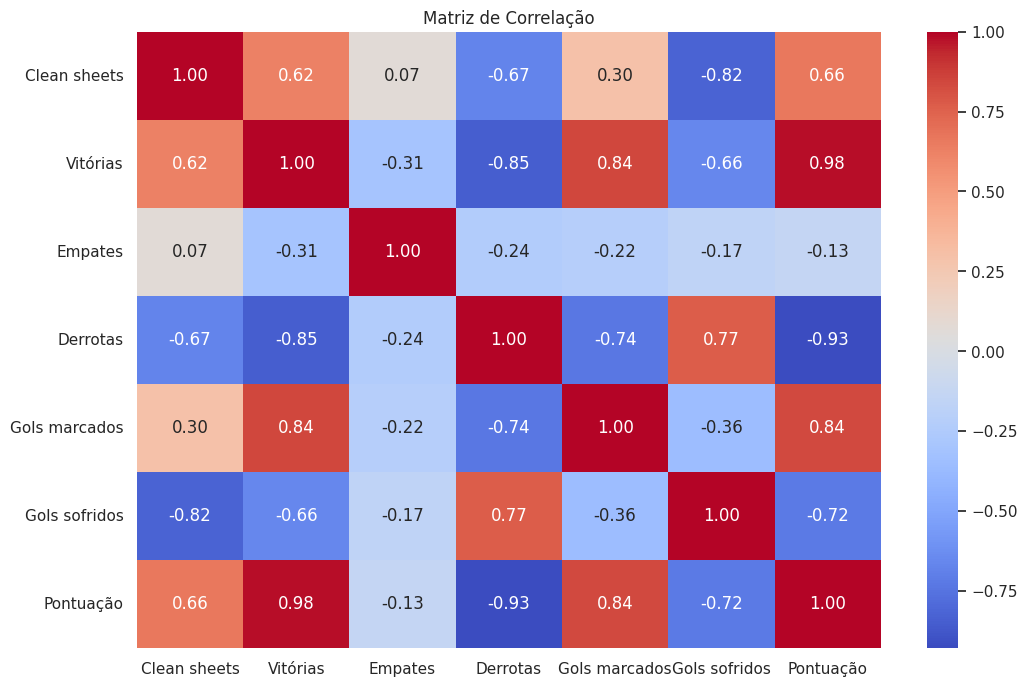

In [12]:
# Colunas numéricas relevantes
corr = df_question2[['CS', 'W', 'D', 'L', 'GF', 'GA_ov', 'Pts']].corr()
corr.columns = ['Clean sheets', 'Vitórias', 'Empates', 'Derrotas', 'Gols marcados', 'Gols sofridos', 'Pontuação']
corr.index = ['Clean sheets', 'Vitórias', 'Empates', 'Derrotas', 'Gols marcados', 'Gols sofridos', 'Pontuação']
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()

A análise da matriz de correlação revela que o desempenho de um time em termos de pontos (Pts) está fortemente associado a vitórias (W), gols marcados (GF) e clean sheets (CS), além de apresentar correlação negativa com derrotas (L) e gols sofridos (GA_ov). Isso pode indicar que, de modo geral, times que vencem mais, marcam mais gols e mantêm a defesa sólida (sem sofrer gols) tendem a conquistar mais pontos na competição. Por outro lado, o número de empates (D) mostra pouca ou nenhuma correlação com o total de pontos, sugerindo que empatar contribui pouco para o sucesso geral de uma equipe.

## Testes de hipótese

Para os testes, foram criadas as seguintes hipóteses:

- Hipótese nula (H₀): Não há correlação significativa entre o número de clean sheets (CS) e o número de pontos (Pts).
- Hipótese alternativa (H₁): Há correlação significativa entre o número de clean sheets (CS) e o número de pontos (Pts).

Dessa forma, seguiremos calcularemos o o coeficiente de Person e o valor-p com o interva-lo de confiança para checar essas hipóteses.

In [72]:
# Cálculo do coeficiente de correlação de Pearson e valor-p
r, p_value = pearsonr(df_question2['CS'], df_question2['Pts'])

# Intervalo de confiança para r usando a transformação de Fisher
def confidence_interval(r, n, confidence=0.95):
    z = np.arctanh(r)
    se = 1 / np.sqrt(n - 3)
    z_crit = norm.ppf(1 - (1 - confidence) / 2)
    z_interval = z + np.array([-1, 1]) * z_crit * se
    return np.tanh(z_interval)

ci_low, ci_high = confidence_interval(r, len(df))

# Resultados
print(f"Coeficiente de correlação de Pearson: {r:.2f}")
print(f"Valor-p: {p_value}")
print(f"Intervalo de confiança (95%): [{ci_low:.2f}, {ci_high:.2f}]")

Coeficiente de correlação de Pearson: 0.66
Valor-p: 2.9860717495491116e-29
Intervalo de confiança (95%): [0.31, 0.85]


Os resultados mostram que existe uma relação positiva entre o número de clean sheets e o número de pontos dos times. O coeficiente de correlação de 0,66 indica uma ligação moderada a forte entre essas duas variáveis. Enquanto o valor-p muito pequeno (praticamente zero) confirma que essa relação é estatisticamente significativa, ou seja, dificilmente aconteceu por acaso. Além disso, o intervalo de confiança de [0,31; 0,85] mostra que, mesmo com alguma variação nos dados, essa correlação continua existindo. Isso sugere que times que sofrem menos gols tendem a conquistar mais pontos.